# Comparing Networks

In this notebook, we want to compare different network to each other.
We will start of with...

- Untrained Model
- Trained Model
- Trained Model (Exact Unlearning)*$^1$

All these model should serve as comparison point for approximate MU Algorithms, which we want to try out

*$^1$ Exact Unlearning: refers to an complete retraining of the Model, without the samples which we want to unlearn.

In [16]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np

from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet
from training import main, train_n_models
from helper import load_models_dict

USED_DATASET = "fashion_mnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = True # <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= False,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

373

In [17]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

We want to include an untrained model as a pour reference point.

Later, we will compare the differently trained (and untrained) models on different metrics. We are thinking, that the **untrained model should always be the furthest neighbor** and see if thats true. Also out of pur curiosity, how do the models compare according to the found metrics to the untrained model.

It could be interesting to see, if the unlearned models tend to be more similar to the "Exact MU Model" or to the "Untrained Model"

The "Trained Model"´s and "Exact Model"´s starting point is the "Untrained Model". That means all models can be traced back to it.

In [18]:
from training import save_model

if not ALLREADY_TRAINED:
    untrained_model = TwoLayerPerceptron() if USED_DATASET in ["mnist", "fashion_mnist"] else ConvNet()
    # save it first
    save_model(untrained_model, name="showcase_untrained", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained", logs=False)

    untrained_ms = {v: TwoLayerPerceptron() for v in range(30)} if USED_DATASET in ["mnist", "fashion_mnist"] else {v: ConvNet() for v in range(30)}

    for i, model in untrained_ms.items():
        save_model(model=model, name=i, path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        untrained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        untrained_showcase_all = ConvNet()
    name = str(untrained_showcase_all)
    untrained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained", map_location=DEVICE,
            weights_only=True
            )
        )
    untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model

This model will be the starting point for all MU algorithms. The more it is important that it does not change throughout the experiments, otherwise we need to run everything again.

Notes Regarding the Dataloader: We included Up-/Downsampling. There is a counter in the Dataset class, which controls, which class is next to provide a sample. From the available pool a sample will be chosen at random.

Reason: The amount of available samples should not influence the performance of the model on certain classes.

Regarding the samples for the class "7": There are more samples of sevens without a middle line than ones with.

Ratio: 
- 6268 (train: 5385, test: 883) 7
- 1025 (train: 880,  test: 145) 7e

Should there be concerns regarding that the bigger part of the sevens (without middle line) will be unlearning?

In [19]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_all = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="all",
        balanced=True,
        dataset_name=USED_DATASET,
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_all = ConvNet()
    name = str(trained_showcase_all)
    trained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [20]:
if not ALLREADY_TRAINED:
    trained_ms = train_n_models(
        sampling_mode="all",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Exact Unlearned Model

This model has the same training conditions as the "Trained Model", with the only difference being, that it had no sevens __with no middle line__

In [21]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_except = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="except_erased",
        balanced=True,
        dataset_name=USED_DATASET,
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_except= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_except = ConvNet()
    name = str(trained_showcase_except)
    trained_showcase_except.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [22]:
if not ALLREADY_TRAINED:
    exact_ms = train_n_models(
        sampling_mode="except_erased",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [23]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Unlearn to ...

In [27]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

27.99387937821448

In [29]:
# ...exact model
a12 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a12

27.96571036875248

#### Trained to ...

In [30]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a21

29.062942915906508

In [31]:
calc_mutlimodel_metric_average(modeltype1=trained_ms, modeltype2=trained_ms, metric="l2_norm")

0.0

#### Exact to ...

In [32]:
# see above

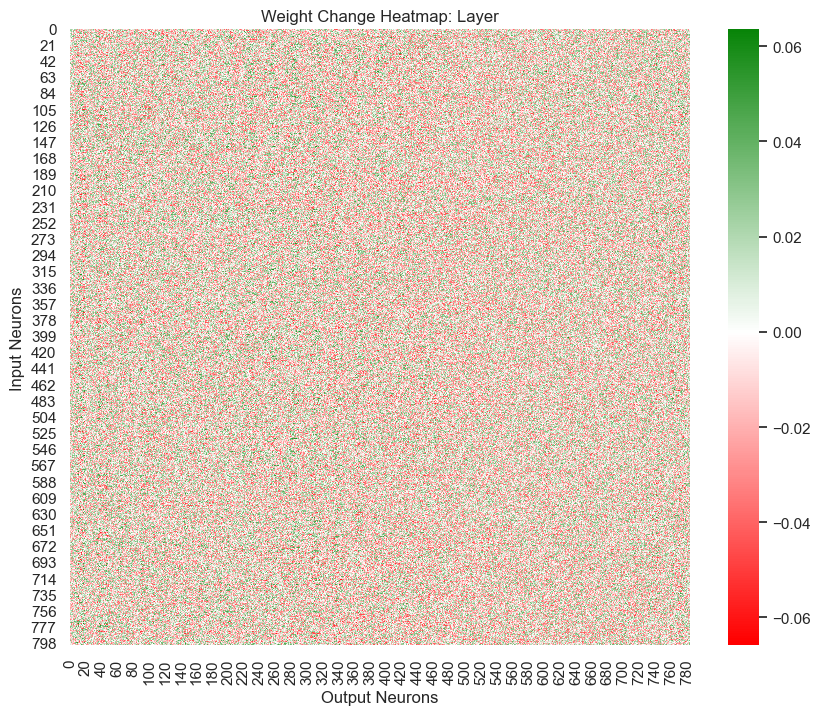

In [33]:
from visualize import visualize_weight_change

visualize_weight_change(weights_before=trained_ms[0].fc1.weight, weights_after=torch.zeros_like(exact_ms[0].fc1.weight))

### Layer-wise Comparison

In [34]:
from metrics import model_layer_wise_difference
lw_dist = {}
for t, mu in zip(trained_ms.values(), exact_ms.values()):
    new = model_layer_wise_difference(t, mu)
    if len(lw_dist) == 0:
        for name in new.keys():
            lw_dist[name] = []
    for name in new.keys():
        lw_dist[name].append(new[name])
for key in lw_dist.keys():
    lw_dist[key] = sum(lw_dist[key])/len(lw_dist[key])
lw_dist

{'fc1.weight': 15740.0435546875,
 'fc1.bias': 22.6561372756958,
 'fc3.weight': 259.5315684000651,
 'fc3.bias': 0.23151248097419738}

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [35]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [36]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.4443164100038244

In [37]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.069837738943438

#### Trained to...

In [38]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.637324291848122

In [39]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.6566421838516886

#### Exact to...

In [40]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.8165057966049678

In [41]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.6481561061866743

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [42]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.0964 - Standard Deviation for D_gesamt: 0.0353


Average Accuracy for D_remain: 0.0931 - Standard Deviation for D_remain: 0.0349


Average Accuracy for 0: 0.0916 - Standard Deviation for 0: 0.2437


Average Accuracy for 1: 0.0578 - Standard Deviation for 1: 0.1750


Average Accuracy for 2: 0.1139 - Standard Deviation for 2: 0.2353


Average Accuracy for 3: 0.1199 - Standard Deviation for 3: 0.2118


Average Accuracy for 4: 0.0579 - Standard Deviation for 4: 0.1411


Average Accuracy for 6: 0.1311 - Standard Deviation for 6: 0.2273


Average Accuracy for 7: 0.0403 - Standard Deviation for 7: 0.0862


Average Accuracy for 8: 0.0963 - Standard Deviation for 8: 0.1602


Average Accuracy for 9: 0.1022 - Standard Deviation for 9: 0.2003


Average Accuracy for 5_all: 0.1526 - Standard Deviation for 5_all: 0.1986


Average Accuracy for 5_remain: 0.1342 - Standard Deviation for 5_remain: 0.1905


Average Accuracy for 5_erased: 0.1868 - Standard Deviation for 5_erased: 0.2407
plotting...


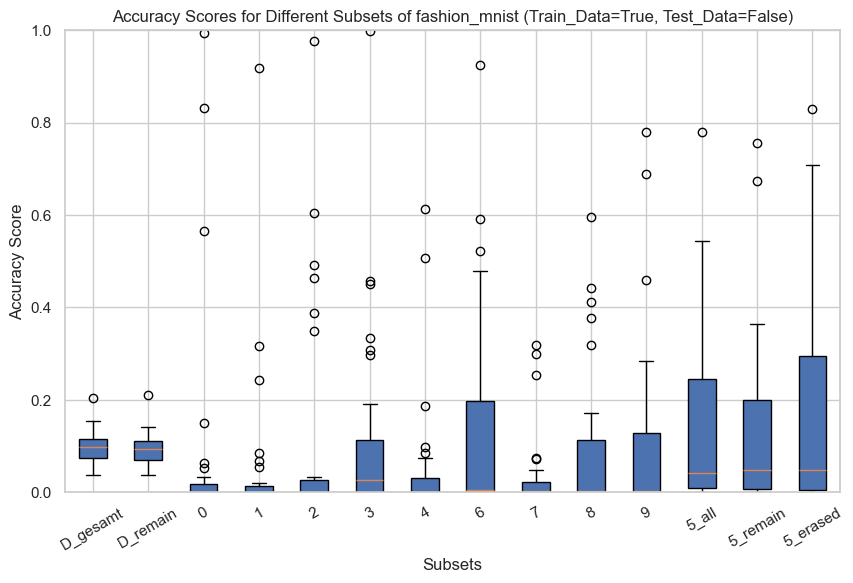

In [43]:
accs["untrained_ms_train"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.0966 - Standard Deviation for D_gesamt: 0.0350


Average Accuracy for D_remain: 0.0932 - Standard Deviation for D_remain: 0.0347


Average Accuracy for 0: 0.0929 - Standard Deviation for 0: 0.2458


Average Accuracy for 1: 0.0565 - Standard Deviation for 1: 0.1729


Average Accuracy for 2: 0.1152 - Standard Deviation for 2: 0.2383


Average Accuracy for 3: 0.1202 - Standard Deviation for 3: 0.2110


Average Accuracy for 4: 0.0566 - Standard Deviation for 4: 0.1385


Average Accuracy for 6: 0.1306 - Standard Deviation for 6: 0.2304


Average Accuracy for 7: 0.0408 - Standard Deviation for 7: 0.0901


Average Accuracy for 8: 0.0976 - Standard Deviation for 8: 0.1646


Average Accuracy for 9: 0.1033 - Standard Deviation for 9: 0.2018


Average Accuracy for 5_all: 0.1522 - Standard Deviation for 5_all: 0.1960


Average Accuracy for 5_remain: 0.1336 - Standard Deviation for 5_remain: 0.1852


Average Accuracy for 5_erased: 0.1834 - Standard Deviation for 5_erased: 0.2396
plotting...


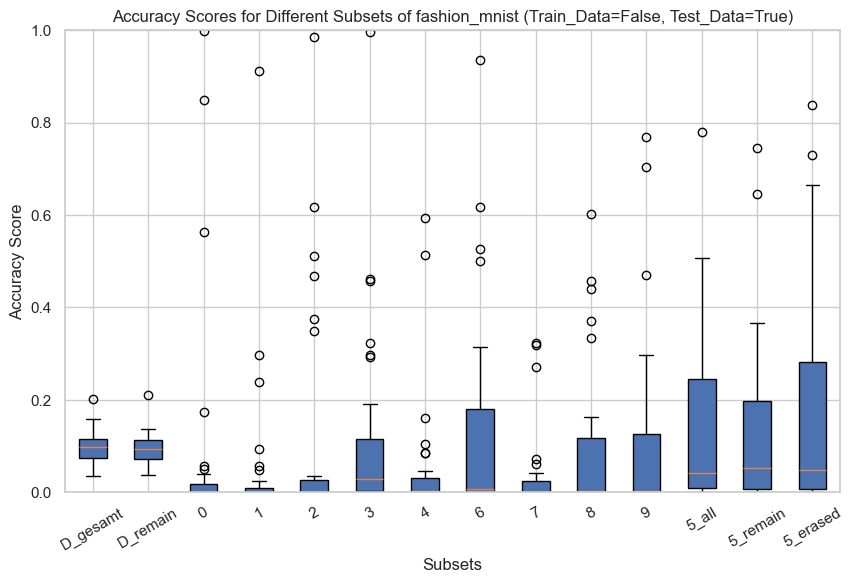

In [44]:
accs["untrained_ms_test"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.8082 - Standard Deviation for D_gesamt: 0.0010


Average Accuracy for D_remain: 0.8051 - Standard Deviation for D_remain: 0.0010


Average Accuracy for 0: 0.8096 - Standard Deviation for 0: 0.0067


Average Accuracy for 1: 0.9382 - Standard Deviation for 1: 0.0012


Average Accuracy for 2: 0.6773 - Standard Deviation for 2: 0.0087


Average Accuracy for 3: 0.8695 - Standard Deviation for 3: 0.0052


Average Accuracy for 4: 0.7898 - Standard Deviation for 4: 0.0093


Average Accuracy for 6: 0.4362 - Standard Deviation for 6: 0.0162


Average Accuracy for 7: 0.8931 - Standard Deviation for 7: 0.0043


Average Accuracy for 8: 0.9366 - Standard Deviation for 8: 0.0018


Average Accuracy for 9: 0.9264 - Standard Deviation for 9: 0.0034


Average Accuracy for 5_all: 0.8059 - Standard Deviation for 5_all: 0.0091


Average Accuracy for 5_remain: 0.7583 - Standard Deviation for 5_remain: 0.0132


Average Accuracy for 5_erased: 0.8945 - Standard Deviation for 5_erased: 0.0052
plotting...


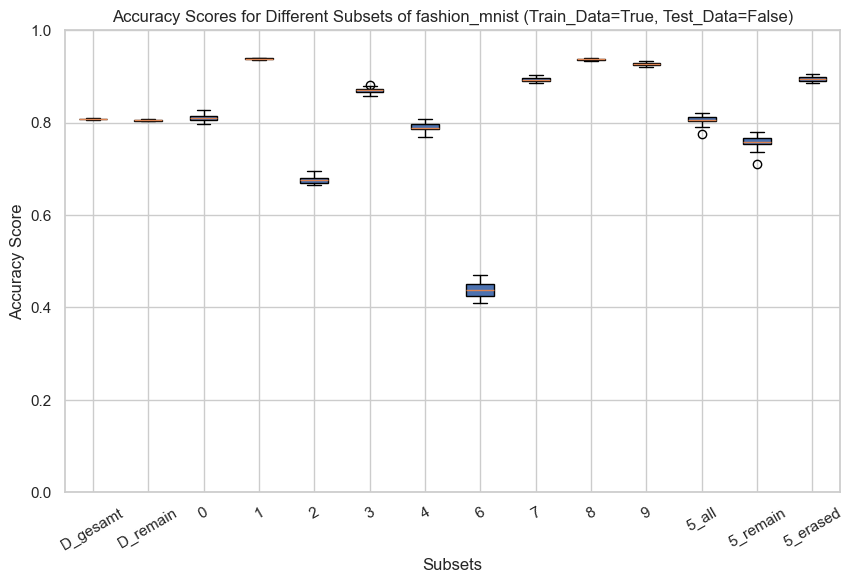

In [45]:
accs["trained_ms_train"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.7960 - Standard Deviation for D_gesamt: 0.0010


Average Accuracy for D_remain: 0.7927 - Standard Deviation for D_remain: 0.0010


Average Accuracy for 0: 0.7875 - Standard Deviation for 0: 0.0076


Average Accuracy for 1: 0.9300 - Standard Deviation for 1: 0.0021


Average Accuracy for 2: 0.6553 - Standard Deviation for 2: 0.0113


Average Accuracy for 3: 0.8585 - Standard Deviation for 3: 0.0066


Average Accuracy for 4: 0.7658 - Standard Deviation for 4: 0.0127


Average Accuracy for 6: 0.4119 - Standard Deviation for 6: 0.0149


Average Accuracy for 7: 0.8911 - Standard Deviation for 7: 0.0050


Average Accuracy for 8: 0.9380 - Standard Deviation for 8: 0.0021


Average Accuracy for 9: 0.9337 - Standard Deviation for 9: 0.0034


Average Accuracy for 5_all: 0.7883 - Standard Deviation for 5_all: 0.0081


Average Accuracy for 5_remain: 0.7321 - Standard Deviation for 5_remain: 0.0119


Average Accuracy for 5_erased: 0.8828 - Standard Deviation for 5_erased: 0.0067
plotting...


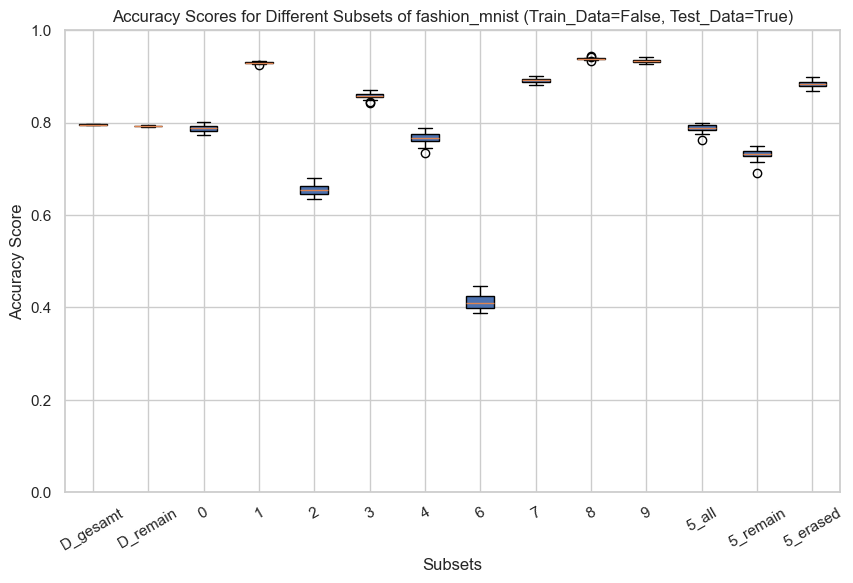

In [46]:
accs["trained_ms_test"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.7870 - Standard Deviation for D_gesamt: 0.0017


Average Accuracy for D_remain: 0.8076 - Standard Deviation for D_remain: 0.0015


Average Accuracy for 0: 0.8098 - Standard Deviation for 0: 0.0073


Average Accuracy for 1: 0.9391 - Standard Deviation for 1: 0.0014


Average Accuracy for 2: 0.6771 - Standard Deviation for 2: 0.0073


Average Accuracy for 3: 0.8693 - Standard Deviation for 3: 0.0039


Average Accuracy for 4: 0.7920 - Standard Deviation for 4: 0.0112


Average Accuracy for 6: 0.4308 - Standard Deviation for 6: 0.0173


Average Accuracy for 7: 0.8808 - Standard Deviation for 7: 0.0045


Average Accuracy for 8: 0.9344 - Standard Deviation for 8: 0.0025


Average Accuracy for 9: 0.9296 - Standard Deviation for 9: 0.0028


Average Accuracy for 5_all: 0.6075 - Standard Deviation for 5_all: 0.0086


Average Accuracy for 5_remain: 0.8164 - Standard Deviation for 5_remain: 0.0059


Average Accuracy for 5_erased: 0.2187 - Standard Deviation for 5_erased: 0.0172
plotting...


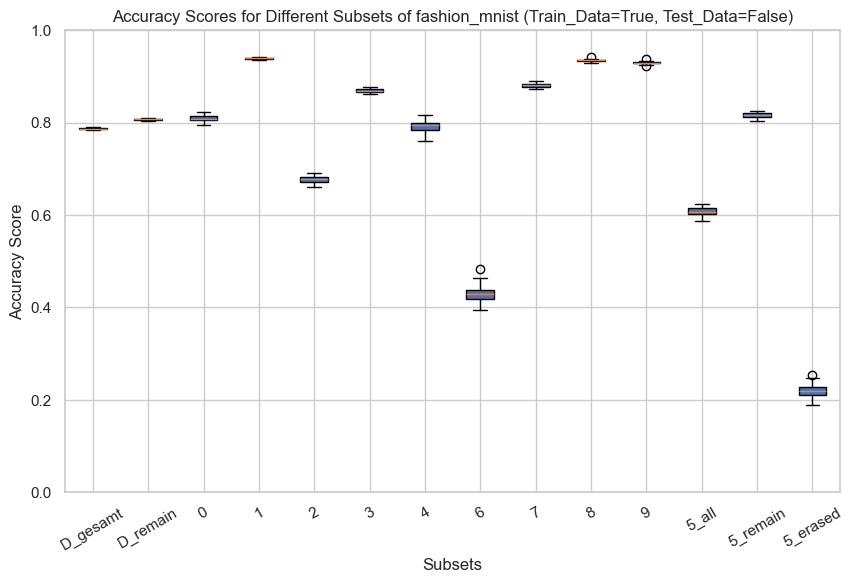

In [47]:
accs["exact_ms_train"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Accuracy for D_gesamt: 0.7732 - Standard Deviation for D_gesamt: 0.0019


Average Accuracy for D_remain: 0.7945 - Standard Deviation for D_remain: 0.0016


Average Accuracy for 0: 0.7870 - Standard Deviation for 0: 0.0077


Average Accuracy for 1: 0.9309 - Standard Deviation for 1: 0.0013


Average Accuracy for 2: 0.6541 - Standard Deviation for 2: 0.0090


Average Accuracy for 3: 0.8580 - Standard Deviation for 3: 0.0049


Average Accuracy for 4: 0.7682 - Standard Deviation for 4: 0.0156


Average Accuracy for 6: 0.4079 - Standard Deviation for 6: 0.0157


Average Accuracy for 7: 0.8847 - Standard Deviation for 7: 0.0041


Average Accuracy for 8: 0.9352 - Standard Deviation for 8: 0.0031


Average Accuracy for 9: 0.9348 - Standard Deviation for 9: 0.0034


Average Accuracy for 5_all: 0.5709 - Standard Deviation for 5_all: 0.0116


Average Accuracy for 5_remain: 0.7778 - Standard Deviation for 5_remain: 0.0080


Average Accuracy for 5_erased: 0.2231 - Standard Deviation for 5_erased: 0.0212
plotting...


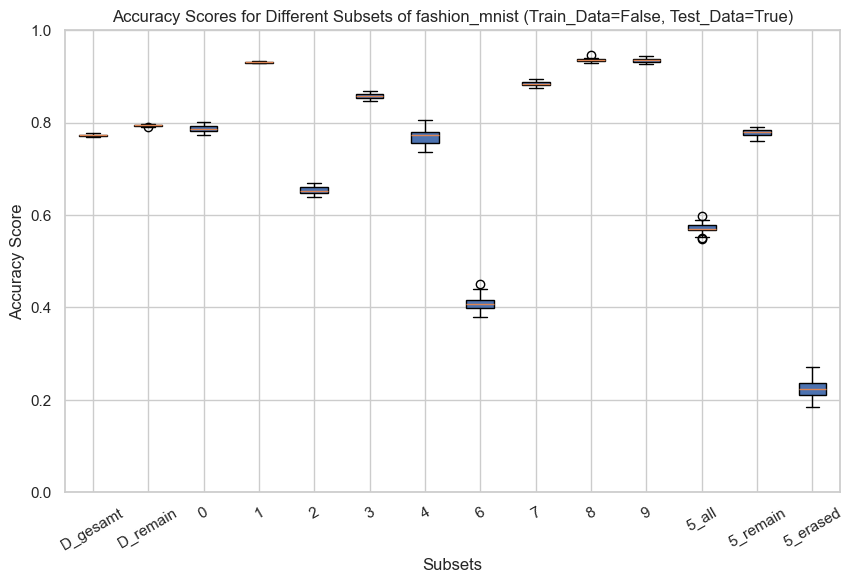

In [48]:
accs["exact_ms_test"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

#### Losses

In [49]:
losses = {}

Starts evaluation for 'fashion_mnist'...


Average Loss for D_gesamt: 0.2889 - Standard Deviation for D_gesamt: 0.0017


Average Loss for D_remain: 0.2890 - Standard Deviation for D_remain: 0.0018


Average Loss for 0: 0.2913 - Standard Deviation for 0: 0.0147


Average Loss for 1: 0.2913 - Standard Deviation for 1: 0.0096


Average Loss for 2: 0.2890 - Standard Deviation for 2: 0.0131


Average Loss for 3: 0.2853 - Standard Deviation for 3: 0.0101


Average Loss for 4: 0.2919 - Standard Deviation for 4: 0.0154


Average Loss for 6: 0.2866 - Standard Deviation for 6: 0.0116


Average Loss for 7: 0.2902 - Standard Deviation for 7: 0.0071


Average Loss for 8: 0.2891 - Standard Deviation for 8: 0.0125


Average Loss for 9: 0.2883 - Standard Deviation for 9: 0.0126


Average Loss for 5_all: 0.2858 - Standard Deviation for 5_all: 0.0067


Average Loss for 5_remain: 0.2861 - Standard Deviation for 5_remain: 0.0061


Average Loss for 5_erased: 0.2862 - Standard Deviation for 5_erased: 0.0083
plotting...


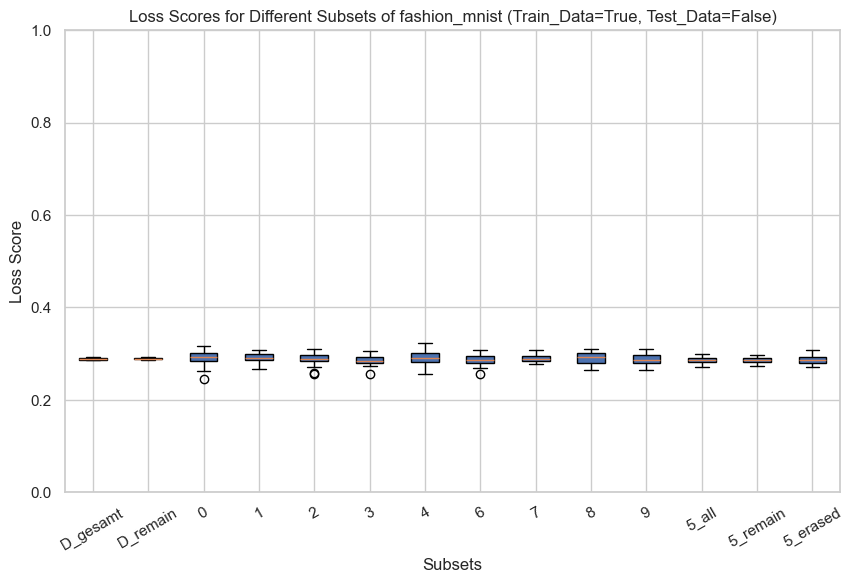

In [50]:
losses["untrained_ms_train"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Loss for D_gesamt: 0.2889 - Standard Deviation for D_gesamt: 0.0016


Average Loss for D_remain: 0.2892 - Standard Deviation for D_remain: 0.0018


Average Loss for 0: 0.2913 - Standard Deviation for 0: 0.0148


Average Loss for 1: 0.2914 - Standard Deviation for 1: 0.0095


Average Loss for 2: 0.2890 - Standard Deviation for 2: 0.0130


Average Loss for 3: 0.2852 - Standard Deviation for 3: 0.0101


Average Loss for 4: 0.2919 - Standard Deviation for 4: 0.0155


Average Loss for 6: 0.2866 - Standard Deviation for 6: 0.0116


Average Loss for 7: 0.2902 - Standard Deviation for 7: 0.0071


Average Loss for 8: 0.2892 - Standard Deviation for 8: 0.0125


Average Loss for 9: 0.2883 - Standard Deviation for 9: 0.0126


Average Loss for 5_all: 0.2858 - Standard Deviation for 5_all: 0.0067


Average Loss for 5_remain: 0.2883 - Standard Deviation for 5_remain: 0.0061


Average Loss for 5_erased: 0.2876 - Standard Deviation for 5_erased: 0.0083
plotting...


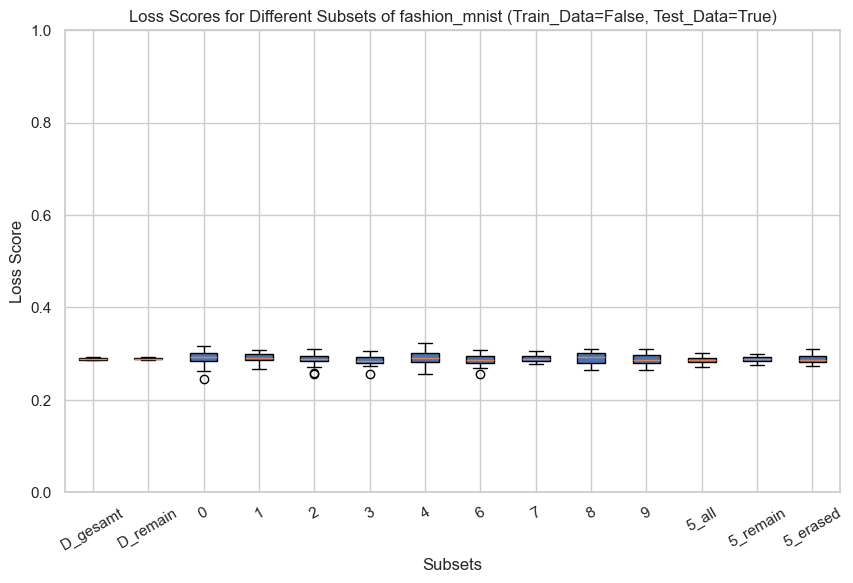

In [51]:
losses["untrained_ms_test"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Loss for D_gesamt: 0.0731 - Standard Deviation for D_gesamt: 0.0002


Average Loss for D_remain: 0.0736 - Standard Deviation for D_remain: 0.0002


Average Loss for 0: 0.0801 - Standard Deviation for 0: 0.0017


Average Loss for 1: 0.0302 - Standard Deviation for 1: 0.0007


Average Loss for 2: 0.1053 - Standard Deviation for 2: 0.0021


Average Loss for 3: 0.0659 - Standard Deviation for 3: 0.0018


Average Loss for 4: 0.0930 - Standard Deviation for 4: 0.0020


Average Loss for 6: 0.1607 - Standard Deviation for 6: 0.0029


Average Loss for 7: 0.0483 - Standard Deviation for 7: 0.0013


Average Loss for 8: 0.0357 - Standard Deviation for 8: 0.0011


Average Loss for 9: 0.0344 - Standard Deviation for 9: 0.0013


Average Loss for 5_all: 0.0773 - Standard Deviation for 5_all: 0.0018


Average Loss for 5_remain: 0.0875 - Standard Deviation for 5_remain: 0.0022


Average Loss for 5_erased: 0.0583 - Standard Deviation for 5_erased: 0.0016
plotting...


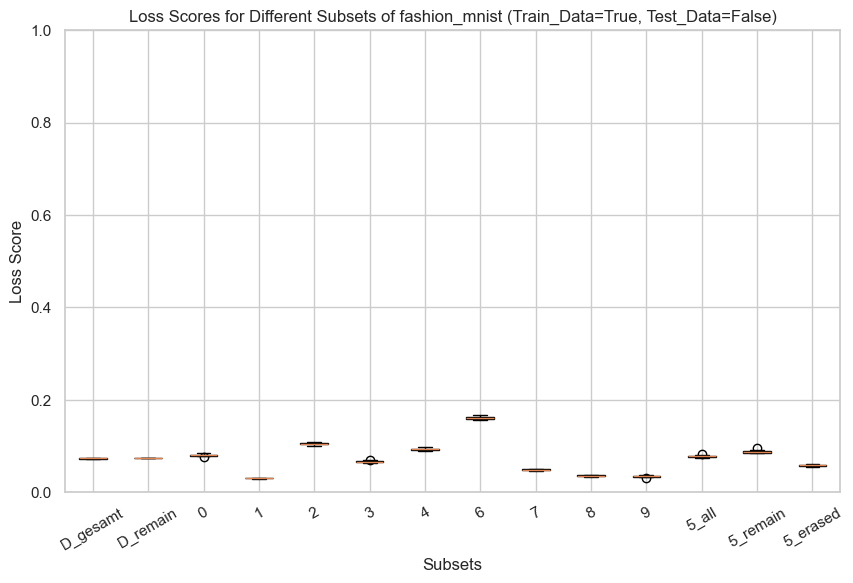

In [52]:
losses["trained_ms_train"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Loss for D_gesamt: 0.0758 - Standard Deviation for D_gesamt: 0.0002


Average Loss for D_remain: 0.0764 - Standard Deviation for D_remain: 0.0002


Average Loss for 0: 0.0850 - Standard Deviation for 0: 0.0019


Average Loss for 1: 0.0338 - Standard Deviation for 1: 0.0008


Average Loss for 2: 0.1090 - Standard Deviation for 2: 0.0021


Average Loss for 3: 0.0727 - Standard Deviation for 3: 0.0019


Average Loss for 4: 0.0959 - Standard Deviation for 4: 0.0022


Average Loss for 6: 0.1669 - Standard Deviation for 6: 0.0029


Average Loss for 7: 0.0452 - Standard Deviation for 7: 0.0013


Average Loss for 8: 0.0364 - Standard Deviation for 8: 0.0012


Average Loss for 9: 0.0337 - Standard Deviation for 9: 0.0013


Average Loss for 5_all: 0.0793 - Standard Deviation for 5_all: 0.0018


Average Loss for 5_remain: 0.0919 - Standard Deviation for 5_remain: 0.0023


Average Loss for 5_erased: 0.0596 - Standard Deviation for 5_erased: 0.0018
plotting...


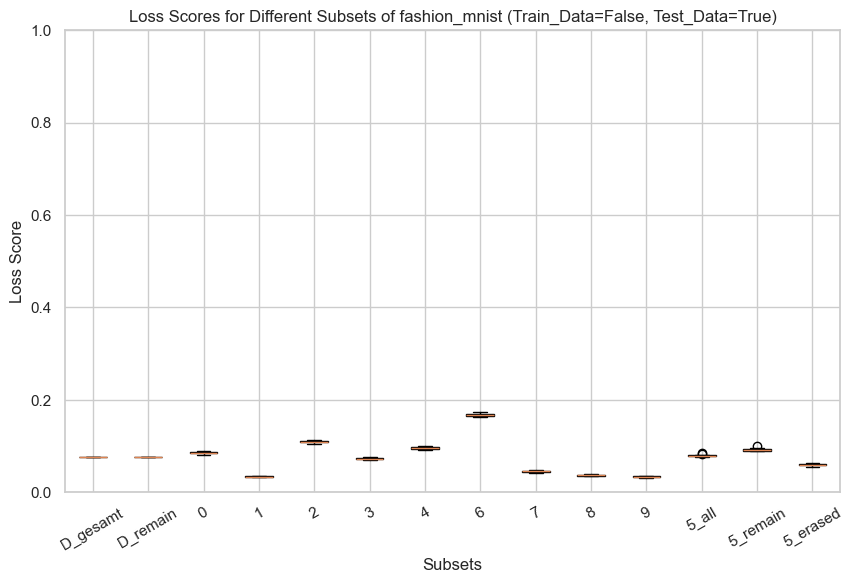

In [53]:
losses["trained_ms_test"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Loss for D_gesamt: 0.0776 - Standard Deviation for D_gesamt: 0.0003


Average Loss for D_remain: 0.0728 - Standard Deviation for D_remain: 0.0002


Average Loss for 0: 0.0798 - Standard Deviation for 0: 0.0023


Average Loss for 1: 0.0296 - Standard Deviation for 1: 0.0009


Average Loss for 2: 0.1051 - Standard Deviation for 2: 0.0020


Average Loss for 3: 0.0660 - Standard Deviation for 3: 0.0016


Average Loss for 4: 0.0926 - Standard Deviation for 4: 0.0025


Average Loss for 6: 0.1617 - Standard Deviation for 6: 0.0025


Average Loss for 7: 0.0506 - Standard Deviation for 7: 0.0011


Average Loss for 8: 0.0364 - Standard Deviation for 8: 0.0013


Average Loss for 9: 0.0321 - Standard Deviation for 9: 0.0011


Average Loss for 5_all: 0.1220 - Standard Deviation for 5_all: 0.0026


Average Loss for 5_remain: 0.0742 - Standard Deviation for 5_remain: 0.0014


Average Loss for 5_erased: 0.2127 - Standard Deviation for 5_erased: 0.0058
plotting...


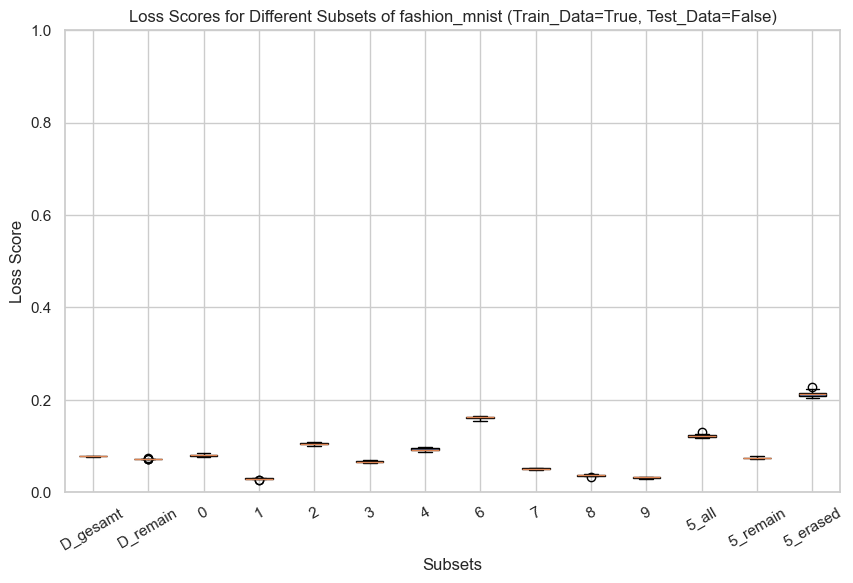

In [54]:
losses["exact_ms_train"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


Average Loss for D_gesamt: 0.0810 - Standard Deviation for D_gesamt: 0.0003


Average Loss for D_remain: 0.0758 - Standard Deviation for D_remain: 0.0002


Average Loss for 0: 0.0847 - Standard Deviation for 0: 0.0024


Average Loss for 1: 0.0331 - Standard Deviation for 1: 0.0010


Average Loss for 2: 0.1089 - Standard Deviation for 2: 0.0020


Average Loss for 3: 0.0727 - Standard Deviation for 3: 0.0017


Average Loss for 4: 0.0956 - Standard Deviation for 4: 0.0026


Average Loss for 6: 0.1678 - Standard Deviation for 6: 0.0024


Average Loss for 7: 0.0480 - Standard Deviation for 7: 0.0011


Average Loss for 8: 0.0374 - Standard Deviation for 8: 0.0013


Average Loss for 9: 0.0316 - Standard Deviation for 9: 0.0010


Average Loss for 5_all: 0.1305 - Standard Deviation for 5_all: 0.0028


Average Loss for 5_remain: 0.0799 - Standard Deviation for 5_remain: 0.0015


Average Loss for 5_erased: 0.2181 - Standard Deviation for 5_erased: 0.0059
plotting...


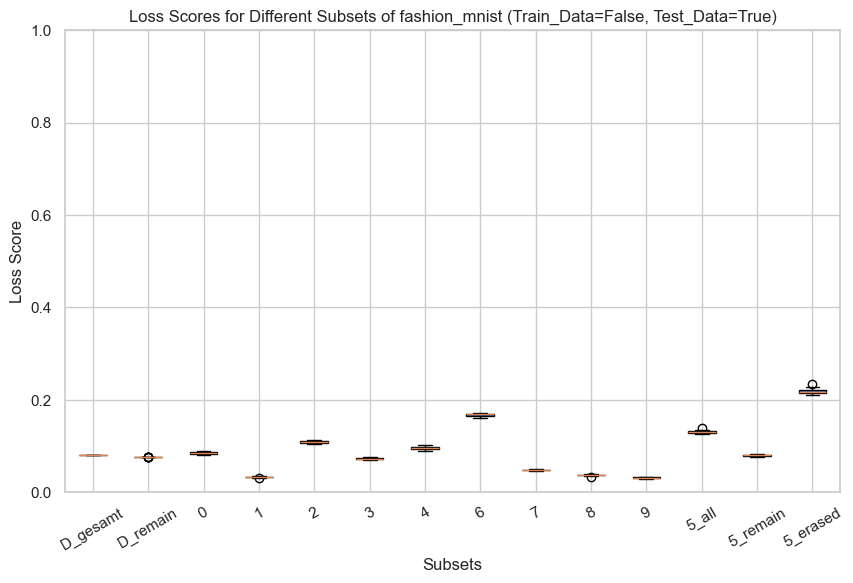

In [55]:
losses["exact_ms_test"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

___